# Regression Challenge

Predicting the selling price of a residential property depends on a number of factors, including the property age, availability of local amenities, and location.

In this challenge, you will use a dataset of real estate sales transactions to predict the price-per-unit of a property based on its features. The price-per-unit in this data is based on a unit measurement of 3.3 square meters.

> **Citation**: The data used in this exercise originates from the following study:
>
> *Yeh, I. C., & Hsu, T. K. (2018). Building real estate valuation models with comparative approach through case-based reasoning. Applied Soft Computing, 65, 260-271.*
>
> It was obtained from the UCI dataset repository (Dua, D. and Graff, C. (2019). [UCI Machine Learning Repository](http://archive.ics.uci.edu/ml). Irvine, CA: University of California, School of Information and Computer Science).

## Review the data

Run the following cell to load the data and view the first few rows.

In [1]:
import utils
import joblib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer


# Modeling
from sklearn.metrics.pairwise import haversine_distances
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV

# Display Pipeline Diagram
from sklearn import set_config
set_config(display="diagram")

# load the training dataset
data = pd.read_csv('data/real_estate.csv')
data.head()

,transaction_date,house_age,transit_distance,local_convenience_stores,latitude,longitude,price_per_unit
0,2012.917,32.0,84.87882,10,24.98298,121.54024,37.9
1,2012.917,19.5,306.59470,9,24.98034,121.53951,42.2
2,2013.583,13.3,561.98450,5,24.98746,121.54391,47.3
3,2013.500,13.3,561.98450,5,24.98746,121.54391,54.8
4,2012.833,5.0,390.56840,5,24.97937,121.54245,43.1


The data consists of the following variables:

- **transaction_date** - the transaction date (for example, 2013.250=2013 March, 2013.500=2013 June, etc.)
- **house_age** - the house age (in years)
- **transit_distance** - the distance to the nearest light rail station (in meters)
- **local_convenience_stores** - the number of convenience stores within walking distance
- **latitude** - the geographic coordinate, latitude
- **longitude** - the geographic coordinate, longitude
- **price_per_unit** house price of unit area (3.3 square meters)

## Train a Regression Model

Your challenge is to explore and prepare the data, identify predictive features that will help predict the **price_per_unit** label, and train a regression model that achieves the lowest Root Mean Square Error (RMSE) you can achieve (which must be less than **7**) when evaluated against a test subset of data.

Add markdown and code cells as required to create your solution.

> **Note**: There is no single "correct" solution. A sample solution is provided in [02 - Real Estate Regression Solution.ipynb](02%20-%20Real%20Estate%20Regression%20Solution.ipynb).

# Solution Train a Regression Model

## Explore Data

All the columns are numeric variables.

In [2]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 414 entries, 0 to 413
Data columns (total 7 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   transaction_date          414 non-null    float64
 1   house_age                 414 non-null    float64
 2   transit_distance          414 non-null    float64
 3   local_convenience_stores  414 non-null    int64  
 4   latitude                  414 non-null    float64
 5   longitude                 414 non-null    float64
 6   price_per_unit            414 non-null    float64
dtypes: float64(6), int64(1)
memory usage: 22.8 KB


There aren't missing values.

In [3]:
data.isna().sum()

transaction_date            0
house_age                   0
transit_distance            0
local_convenience_stores    0
latitude                    0
longitude                   0
price_per_unit              0
dtype: int64

We have some outliers in **transit_distance**, **latitude**, **longitude** and **price** variables but we are not going to drop it beacuse there are few outliers.

Minimum:2012.67
Mean:2013.15
Median:2013.17
Mode:2013.42
Maximum:2013.58

Minimum:0.00
Mean:17.71
Median:16.10
Mode:0.00
Maximum:43.80

Minimum:23.38
Mean:1083.89
Median:492.23
Mode:289.32
Maximum:6488.02

Minimum:0.00
Mean:4.09
Median:4.00
Mode:0.00
Maximum:10.00

Minimum:24.93
Mean:24.97
Median:24.97
Mode:24.97
Maximum:25.01

Minimum:121.47
Mean:121.53
Median:121.54
Mode:121.54
Maximum:121.57

Minimum:7.60
Mean:37.98
Median:38.45
Mode:24.70
Maximum:117.50



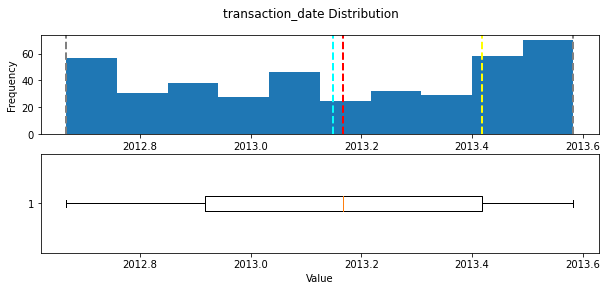

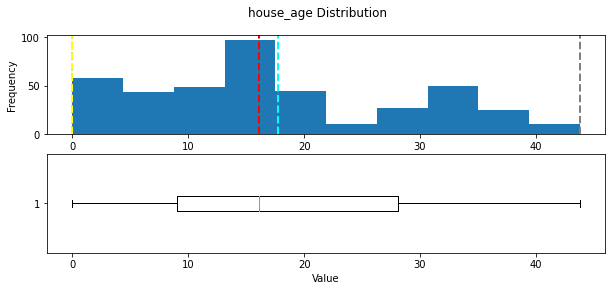

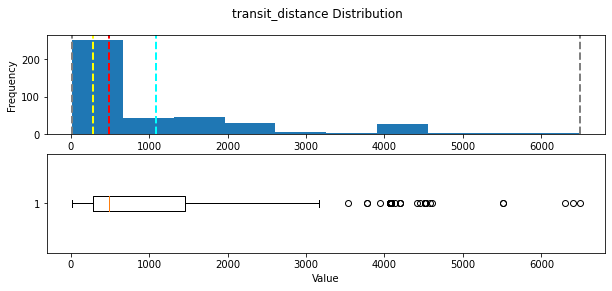

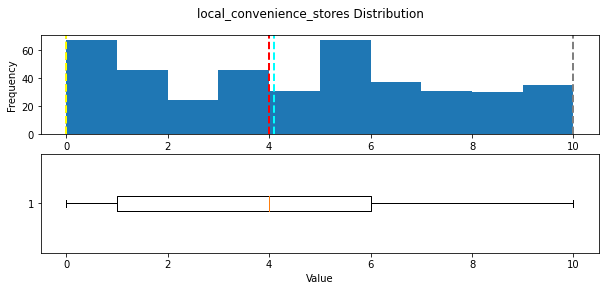

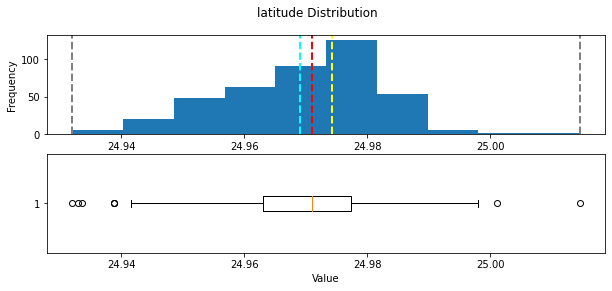

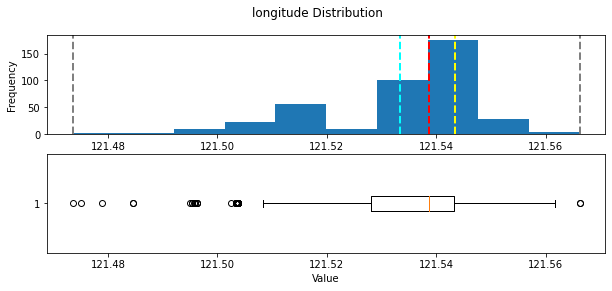

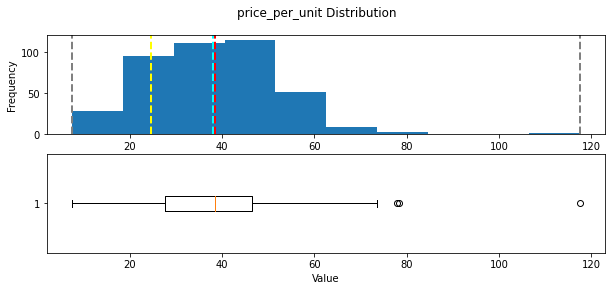

In [4]:
# Data Distribution
for col in data.columns:
    utils.show_distribution(data[col], col)

There are a little linear relationship between **price_per_unit** and **house_age**(negative), **transit_distance**(negative), **local_convenience_stores**(positive), **latitude**(positive), **longitude**(positive). This relationship is confirmed by the correlation. We are not going to use **transaction_date** in this model beacuse it doesn't has a cleare relationship with price_per_unit

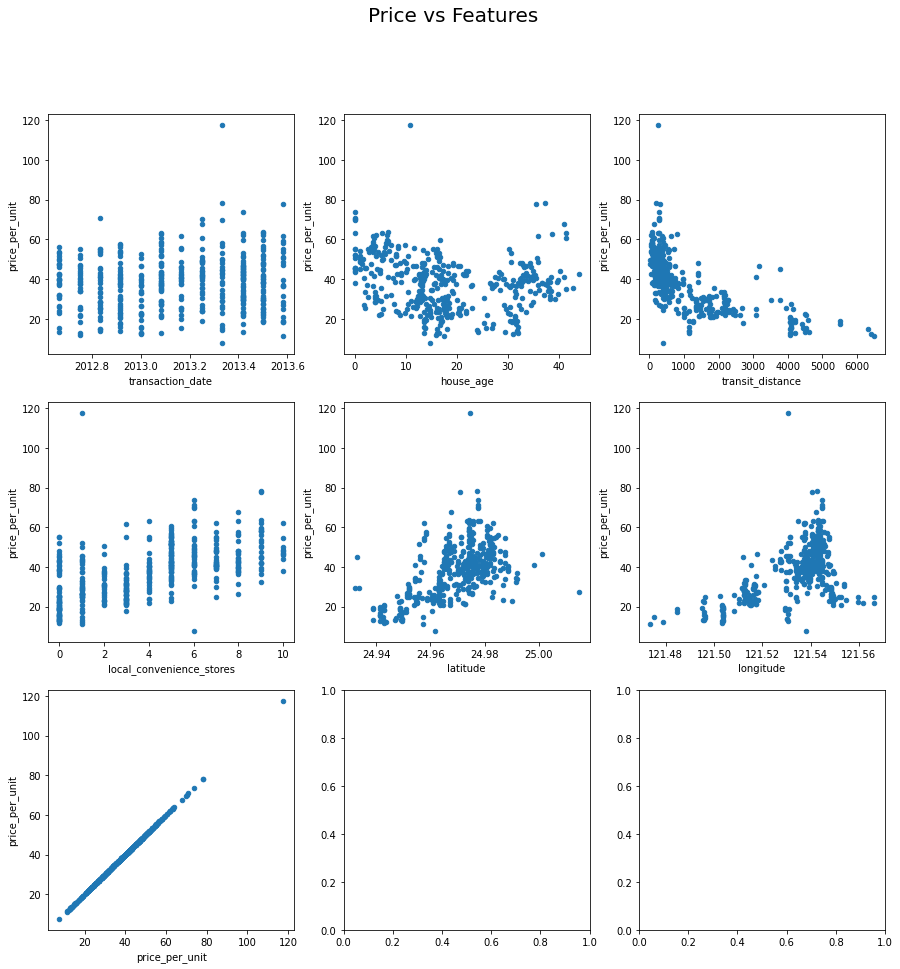

In [5]:
# Scatter Plot -> Columns vs Price
fig, axes = plt.subplots(nrows = 3, ncols = 3, figsize = (15, 15))
axes = axes.flat
for i, col in enumerate(data.columns):
    data.plot.scatter(x = col, y = "price_per_unit", ax = axes[i])
fig.suptitle("Price vs Features", size = 20);

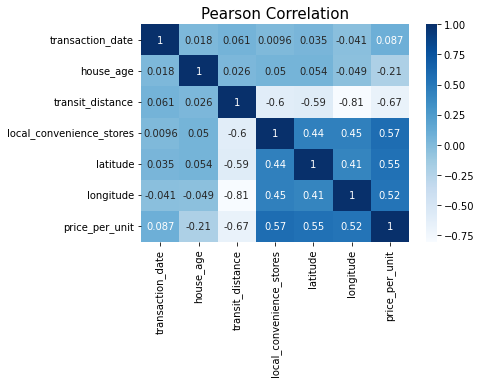

In [6]:
# Pearson Correlation
sns.heatmap(data.corr(method = "pearson"), 
            cmap = "Blues", 
            annot = True)
plt.title("Pearson Correlation", size = 15);

## Preprocess Data

In [7]:
# Random Seed
RANDOM_STATE = 321

# Target and Predictor Variables
useful_variables =["house_age", "transit_distance", "local_convenience_stores", "latitude", "longitude"]
X = data[useful_variables]
y = data["price_per_unit"]

# Split Data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = RANDOM_STATE)

print(f"X_train has: {X_train.shape[0]} rows.")
print(f"X_test has: {X_test.shape[0]} rows.")
print(f"y_train has: {y_train.shape[0]} rows.")
print(f"y_test has: {y_test.shape[0]} rows.")

X_train has: 310 rows.
X_test has: 104 rows.
y_train has: 310 rows.
y_test has: 104 rows.


In [8]:
# Preprocessing Steps for Numeric Features
numeric_transformer = Pipeline([
    ("scaler", StandardScaler())
])

# Join Preprocessing Steps
preprocessor = ColumnTransformer([
    ("numeric_features", numeric_transformer, useful_variables)
])

### Lasso

In [9]:
# Preprocessing Steps and Lasso Model
pipeline_lasso = Pipeline([
    ("preprocessor", preprocessor),
    ("model", Lasso())
])

model_lasso = pipeline_lasso.fit(X_train, y_train)

# Get predictions
predictions = model_lasso.predict(X_test)

# Display metrics
mse = mean_squared_error(y_test, predictions)
print("MSE:", mse)
rmse = np.sqrt(mse)
print("RMSE:", rmse)
r2 = r2_score(y_test, predictions)
print("R2:", r2)


MSE: 62.59114526212402
RMSE: 7.911456582837577
R2: 0.6432744136324859


### RandomForest

MSE: 48.93879161969615
RMSE: 6.995626606651912
R2: 0.721083244865661


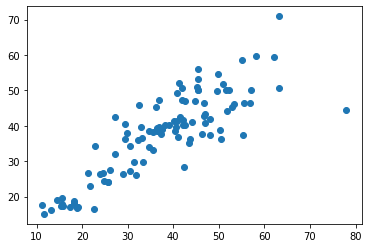

In [10]:
# Preprocessing Steps and RandomForestRegressor Model
pipeline_forest = Pipeline([
    ("preprocessor", preprocessor),
    ("model", RandomForestRegressor(random_state = RANDOM_STATE))
])

model_forest = pipeline_forest.fit(X_train, y_train)

# Get predictions
predictions = model_forest.predict(X_test)

# Display metrics
mse = mean_squared_error(y_test, predictions)
print("MSE:", mse)
rmse = np.sqrt(mse)
print("RMSE:", rmse)
r2 = r2_score(y_test, predictions)
print("R2:", r2)

plt.scatter(x = y_test, y = predictions);

### Feature Engineering

In [11]:
# Random Seed
RANDOM_STATE = 321

# Target and Predictor Variables
coords_columns = ["latitude", "longitude"]
useful_variables =["house_age", "transit_distance", "local_convenience_stores", "latitude", "longitude"]
X = data[useful_variables]
y = data["price_per_unit"]

# Split Data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = RANDOM_STATE)

print(f"X_train has: {X_train.shape[0]} rows.")
print(f"X_test has: {X_test.shape[0]} rows.")
print(f"y_train has: {y_train.shape[0]} rows.")
print(f"y_test has: {y_test.shape[0]} rows.")

X_train has: 310 rows.
X_test has: 104 rows.
y_train has: 310 rows.
y_test has: 104 rows.


In [12]:
# Preprocessing Steps for Numeric Features
numeric_pipeline = Pipeline([
    ("scaler", StandardScaler()) # In case of random forest is not necessary StandardScaler
])

# Preprocessing Steps for Coord Features
coordinates_pipeline = Pipeline([
    ("cluster", utils.KMeans_Transformer(num_clusters = 5, seed = 123)), # FEATURE ENGINEERING
    #("encoder", OneHotEncoder(handle_unknown = "ignore"))
])

# Preprocessor by Columns
preprocessor = ColumnTransformer([
    ("numeric_features", numeric_pipeline, [c for c in useful_variables if not(c in coords_columns)]),
    ("coords_features", coordinates_pipeline, coords_columns)
], remainder = "drop")

In [13]:
# Preprocessing Steps and RandomForestRegressor Model
pipeline_forest = Pipeline([
    ("preprocessor", preprocessor),
    ("model", RandomForestRegressor(random_state = RANDOM_STATE))
])


In [14]:
forest_grid = {"preprocessor__coords_features__cluster__num_clusters": range(2, 15)}

cv_forest = GridSearchCV(estimator = pipeline_forest,
                         param_grid = forest_grid,
                         cv = 5,
                         refit = True,
                         verbose = True)
cv_forest.fit(X_train, y_train)

Fitting 5 folds for each of 13 candidates, totalling 65 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('numeric_features',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         ['house_age',
                                                                          'transit_distance',
                                                                          'local_convenience_stores']),
                                                                        ('coords_features',
                                                                         Pipeline(steps=[('cluster',
                                                                                          KMeans_Transformer(num_clusters=5,
                                                                                                             seed=123))]),
                                                                         ['latitude',
                                                                          'longitude'])])),
                                       ('model',
                                        RandomForestRegressor(random_state=321))]),
             param_grid={'preprocessor__coords_features__cluster__num_clusters': range(2, 15)},
             verbose=True)

In [15]:
best_forest = cv_forest.best_estimator_
predictions = best_forest.predict(X_test)


In [16]:
# Display metrics
mse = mean_squared_error(y_test, predictions)
print("MSE:", mse)
rmse = np.sqrt(mse)
print("RMSE:", rmse)
r2 = r2_score(y_test, predictions)
print("R2:", r2)

MSE: 42.528302635564614
RMSE: 6.521372756986416
R2: 0.7576185316412909


In [17]:
best_forest.steps[1][1].feature_importances_

array([0.26014029, 0.65084675, 0.04097838, 0.04803458])

## Use the Trained Model

Save your trained model, and then use it to predict the price-per-unit for the following real estate transactions:

| transaction_date | house_age | transit_distance | local_convenience_stores | latitude | longitude |
| ---------------- | --------- | ---------------- | ------------------------ | -------- | --------- |
|2013.167|16.2|289.3248|5|24.98203|121.54348|
|2013.000|13.6|4082.015|0|24.94155|121.50381|

In [18]:
# Save the model as a pickle file
filename = './price_real-state.pkl'
joblib.dump(model_forest, filename)

['./price_real-state.pkl']

In [19]:
loaded_model = joblib.load(filename)

X_new = np.array([[16.2,289.3248,5,24.98203,121.54348],
                  [13.6,4082.015,0,24.94155,121.50381]]).astype('float64')
X_new = pd.DataFrame(X_new, columns = useful_variables)

In [20]:
loaded_model.predict(X_new)

array([50.6860381 , 17.27603333])